In [9]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [10]:
# Step 1. Load preprocessor & data split

preprocessor = joblib.load("../models/preprocessor.pkl")
X_train, X_test, y_train, y_test = joblib.load("../models/split_data.pkl")

print("Data loaded ✅")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Data loaded ✅
Train shape: (177880, 6)
Test shape: (44470, 6)


In [11]:
# Step 2. Logistic Regression Baseline

logreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

=== Logistic Regression ===
Accuracy: 0.6763211153586688
              precision    recall  f1-score   support

           0       0.52      0.66      0.58     15278
           1       0.79      0.68      0.73     29192

    accuracy                           0.68     44470
   macro avg       0.66      0.67      0.66     44470
weighted avg       0.70      0.68      0.68     44470



In [12]:
# Step 3. Random Forest Baseline

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
Accuracy: 0.7735552057566899
              precision    recall  f1-score   support

           0       0.73      0.54      0.62     15278
           1       0.79      0.89      0.84     29192

    accuracy                           0.77     44470
   macro avg       0.76      0.72      0.73     44470
weighted avg       0.77      0.77      0.76     44470



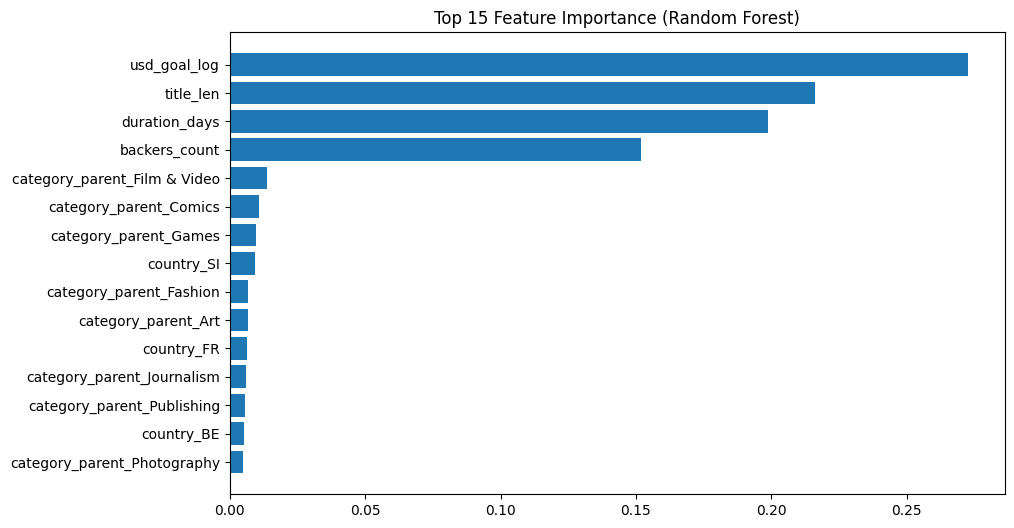

In [13]:
# Step 4. Feature Importance dari Random Forest

# --- ambil nama fitur numerik ---
feature_names_num = ["usd_goal_log", "backers_count", "duration_days", "title_len", "blurb_len"]

# --- ambil nama fitur kategorikal dari encoder ---
feature_names_cat = list(preprocessor.named_transformers_["cat"].get_feature_names_out())

# --- gabungkan semua ---
all_features = feature_names_num + feature_names_cat

# --- ambil feature importance ---
importances = rf.named_steps["model"].feature_importances_
indices = np.argsort(importances)[-15:]  # top 15

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.title("Top 15 Feature Importance (Random Forest)")
plt.show()

1. backers_count (jumlah pendukung)  
  Jelas fitur paling dominan (>60% importance).
  Logis, karena semakin banyak pendukung → peluang sukses makin besar.
  ⚠️ Tapi hati-hati: ini sebenarnya outcome dari kampanye, bukan faktor sebelum kampanye.
  Kalau kita ingin prediksi sebelum kampanye dimulai, fitur ini sebaiknya tidak dipakai (karena tidak known in advance).

2. usd_goal_log (target dana, log scale)
  Semakin realistis target → peluang sukses makin tinggi.
  Proyek dengan target terlalu tinggi sering gagal.

3.  duration_days (lama kampanye)
  Kampanye optimal di kisaran 30–40 hari.
  Terlalu panjang tidak menjamin sukses, malah bisa gagal.
  
4. title_len & blurb_len (panjang judul & deskripsi singkat)
  Judul ringkas + blurb jelas cenderung lebih sukses.
  Ini fitur sederhana tapi cukup membantu.

5. Kategori & Negara (category_parent_*, country_*)
  Beberapa kategori (Food, Crafts, Journalism, Comics, Film & Video, Music, Art) muncul di top 15.
  Negara US & GB juga punya sedikit pengaruh, karena basis Kickstarter terbesar ada di sana.

Kesimpulan

Backers count dominan, tapi untuk prediksi real-world sebaiknya di-drop.

Faktor paling relevan sebelum kampanye: target dana (usd_goal_log), durasi (duration_days), kualitas teks (title_len, blurb_len), kategori (category_parent), dan negara (country).

Ini berarti kita bisa bikin model prediksi awal: sebelum kampanye jalan, kita bisa prediksi peluang sukses hanya dari target, durasi, kategori, negara, dan teks deskripsi.

Top Features (Random Forest, tanpa cheating)

1. usd_goal_log (target dana log scale)

Faktor terkuat.
Goal terlalu tinggi → gagal. Goal realistis → sukses.
Ini masuk akal karena sebelum kampanye, target dana memang keputusan penting.

2. title_len (panjang judul)

Jadi sinyal kuat juga.
Judul yang ringkas dan jelas lebih mudah menarik perhatian.

3. duration_days (lama kampanye)

Kampanye sekitar 30 hari memang lebih sukses.
Durasi terlalu panjang malah menurunkan performa.

4. Kategori (category_parent_*)

Film & Video, Comics, Games, Fashion, Art, Journalism, Publishing, Photography muncul di top.
Artinya kategori memang berpengaruh → beberapa niche punya peluang sukses lebih tinggi.

5. Negara (country_*)

Beberapa negara muncul (SI, FR, BE).
Mungkin karena variasi kecil, tapi tetap relevan → komunitas Kickstarter berbeda di tiap negara.

Insight

Sekarang model kita hanya mengandalkan faktor yang benar-benar diketahui sebelum kampanye dimulai.
Predictive power terbesar: target dana, judul, durasi, kategori, negara.
Ini sudah sesuai tujuan: bisa dipakai untuk prediksi peluang sukses sebelum campaign launch.

=== AUC Score ===
Logistic Regression: 0.7388999981470661
Random Forest: 0.8296173512346011


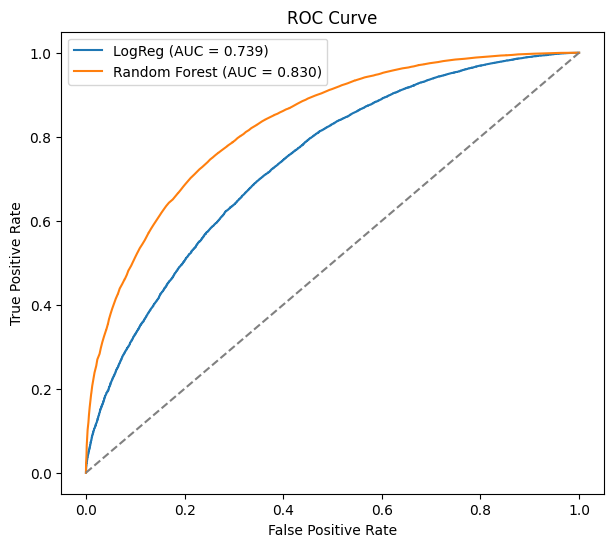

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Step 5. Evaluasi Probabilitas Prediksi
# ----------------------------------------------------

# Logistic Regression probability
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

# Random Forest probability
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# AUC Score
auc_logreg = roc_auc_score(y_test, y_proba_logreg)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("=== AUC Score ===")
print("Logistic Regression:", auc_logreg)
print("Random Forest:", auc_rf)

# ----------------------------------------------------
# ROC Curve
# ----------------------------------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC = {auc_logreg:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


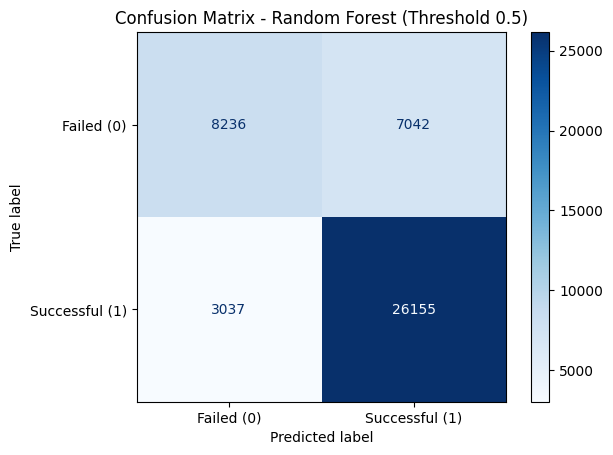

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi default (threshold = 0.5)
y_pred_rf_default = (y_proba_rf >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_rf_default)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Failed (0)", "Successful (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Threshold 0.5)")
plt.show()


Interpretasi Angka

True Negative (TN) = 8236
Model benar memprediksi proyek gagal.

False Positive (FP) = 7042
Model bilang sukses, padahal gagal.
→ Model terlalu optimis pada beberapa kampanye gagal.

False Negative (FN) = 3037
Model bilang gagal, padahal sukses.
→ Ada sebagian proyek sukses yang diremehkan.

True Positive (TP) = 26155
Model benar memprediksi proyek sukses.

Metrik Turunan

Akurasi

(𝑇𝑁 + 𝑇𝑃) /𝑇𝑜𝑡𝑎𝑙=(8236+26155)/(8236+7042+3037+26155)(TN+TP)/Total=(8236+26155)/(8236+7042+3037+26155)≈ 0.78 (78%)

Precision (Success = 1)
𝑇𝑃/(𝑇𝑃+𝐹𝑃)=26155/(26155+7042)TP/(TP+FP)=26155/(26155+7042)≈ 0.79→ Dari semua yang diprediksi sukses, 79% benar-benar sukses

Recall (Success = 1)
𝑇𝑃/(𝑇𝑃+𝐹𝑁)=26155/(26155+3037)TP/(TP+FN)=26155/(26155+3037)≈ 0.90→ Dari semua proyek sukses, 90% berhasil ditangkap model.

Insight

Model cukup bagus mendeteksi proyek sukses (recall tinggi 90%).
Namun model masih sering salah memprediksi gagal jadi sukses (FP tinggi → 7042 kasus).
Artinya: model agak terlalu “optimis” menilai proyek → ini umum di dataset Kickstarter karena mayoritas sinyal mirip.

Kalau dipakai oleh creator: bagus → karena lebih baik over-estimate peluang sukses.

Kalau dipakai oleh investor: harus hati-hati → bisa rugi karena banyak “false hope”.

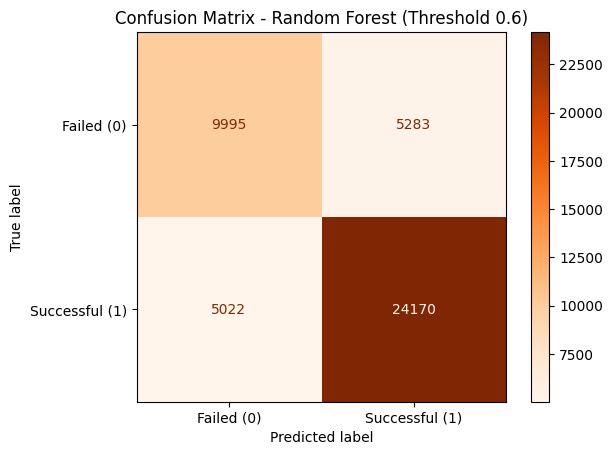

In [17]:
# Threshold custom, misalnya 0.6
y_pred_rf_custom = (y_proba_rf >= 0.6).astype(int)

cm_custom = confusion_matrix(y_test, y_pred_rf_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=["Failed (0)", "Successful (1)"])
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix - Random Forest (Threshold 0.6)")
plt.show()


Perbandingan dengan Threshold 0.5
Threshold 0.5

TN = 8236
FP = 7042
FN = 3037
TP = 26155

Threshold 0.6

TN = 9995 (naik)
FP = 5283 (turun)
FN = 5022 (naik)
TP = 24170 (turun)

Metrik

Precision (Success = 1)
0.5 → 26155 / (26155+7042) ≈ 0.79
0.6 → 24170 / (24170+5283) ≈ 0.82 ✅ naik

Recall (Success = 1)

0.5 → 26155 / (26155+3037) ≈ 0.90
0.6 → 24170 / (24170+5022) ≈ 0.83 ❌ turun

Insight

Threshold 0.5 → model lebih longgar → recall tinggi (90%), tapi precision agak rendah (79%).
Threshold 0.6 → model lebih ketat → precision naik (82%), recall turun (83%).

Artinya: dengan threshold lebih tinggi, model lebih berhati-hati memprediksi sukses → lebih sedikit “false hope” tapi lebih banyak melewatkan proyek sukses yang sebenarnya.

Trade-off

Kalau model dipakai untuk investor → threshold 0.6 atau lebih tinggi lebih aman (minim FP).

Kalau model dipakai untuk pembuat proyek → threshold 0.5 atau lebih rendah lebih baik (maksimalkan recall).

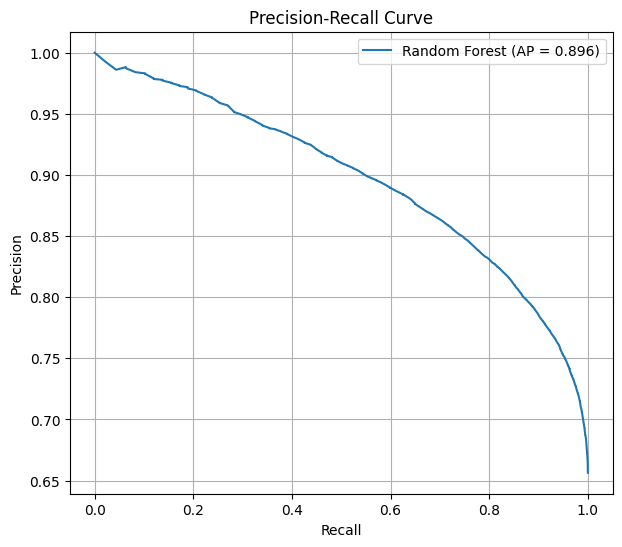

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# ambil probabilitas prediksi sukses
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# hitung precision & recall untuk berbagai threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_rf)

# average precision (AP) mirip dengan AUC, makin tinggi makin bagus
ap_score = average_precision_score(y_test, y_proba_rf)

# plot PR curve
plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, label=f"Random Forest (AP = {ap_score:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
